<a href="https://colab.research.google.com/github/LTucker98/Lewis-Tucker/blob/main/AI_WORK_17015710.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TROPICAL** **FISH** 

# WEEK 1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/TropicalFish_Dataset.zip' > /dev/null

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

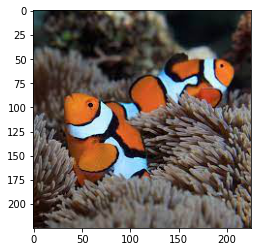

In [ ]:
image = mpimg.imread('/content/TropicalFish_Dataset/train/Clownfish/download (1).jpg')
plt.imshow(image)
plt.show()

# WEEK 2

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/TropicalFish_Dataset.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'TropicalFish_Dataset'

# define batch size
batch_size = 4

# # define transforms (grayscale)
# transform_gs = transforms.Compose([transforms.Grayscale(), # convert colour images to greyscale
#                                 transforms.Resize(28), # resize to 28x?
#                                 transforms.CenterCrop(28), # take a square (28x28) crop from the centre
#                                 transforms.ToTensor(), # convert data to torch.FloatTensor
#                                 transforms.Normalize(0.5, 0.5)]) # normalise with mean 0.5 and standard deviation 0.5

# define transforms (colour)
transform = transforms.Compose([transforms.Resize(28), # resize to 28x?
                                transforms.CenterCrop(28), # take a square (28x28) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

torch.Size([4])


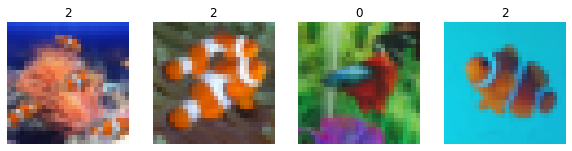

In [ ]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels.shape)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Betta Fish, 1 is Blue Tang, 2 is Clownfish, 3 is Lion Fish

In [ ]:
# if using greyscale images, image size 28x28x1 = 784
# if using colour images, image size 28x28x3 = 2352
input_size = 2352
                                                                   
from torch import nn, optim
import torch.nn.functional as F

# define the NN architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # number of hidden nodes in each layer
        hidden_1 = 1028
        hidden_2 = 512
        hidden_3 = 256
        numberOfClasses = 4
        # linear layers
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, numberOfClasses) 
        # Dropout module with 0.2 drop probability - to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(-1, input_size)
        # add hidden layers, with relu activation function, and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # add output layer with logSoftmax
        x = F.log_softmax(self.fc4(x), dim=1) 
        return x

# initialise the NN
model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=2352, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# specify loss function (negative log likelihood loss)
criterion = nn.NLLLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MLP_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.971944 	Validation Loss: 1.127854
Validation loss decreased (inf --> 1.127854).  Saving model ...
Epoch: 2 	Training Loss: 1.350004 	Validation Loss: 1.078506
Validation loss decreased (1.127854 --> 1.078506).  Saving model ...
Epoch: 3 	Training Loss: 1.400992 	Validation Loss: 1.681875
Epoch: 4 	Training Loss: 1.171905 	Validation Loss: 1.048188
Validation loss decreased (1.078506 --> 1.048188).  Saving model ...
Epoch: 5 	Training Loss: 1.286443 	Validation Loss: 1.202905
Epoch: 6 	Training Loss: 1.141419 	Validation Loss: 2.746955
Epoch: 7 	Training Loss: 1.162717 	Validation Loss: 1.369862
Epoch: 8 	Training Loss: 1.001647 	Validation Loss: 1.575045
Epoch: 9 	Training Loss: 1.177566 	Validation Loss: 2.165778
Epoch: 10 	Training Loss: 1.082311 	Validation Loss: 1.721958
Epoch: 11 	Training Loss: 1.080001 	Validation Loss: 1.822331
Epoch: 12 	Training Loss: 1.327765 	Validation Loss: 1.308930
Epoch: 13 	Training Loss: 0.962830 	Validation Loss: 2.857189
E

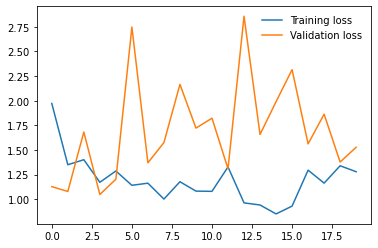

In [ ]:
# Visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('MLP_model.pt'))

<All keys matched successfully>

In [ ]:
# 
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.943777

Test Accuracy of     0:  6% ( 1/15)
Test Accuracy of     1: 80% (12/15)
Test Accuracy of     2: 80% (12/15)
Test Accuracy of     3: 80% (12/15)

Test Accuracy (Overall): 61% (37/60)


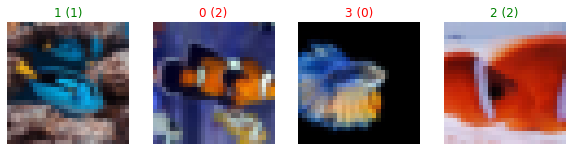

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

# 0 is good, 1 is poor

# WEEK 3

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/TropicalFish_Dataset.zip' > /dev/null

replace TropicalFish_Dataset/test/Bettafish/OIP (42).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# dataset directory
data_dir = 'TropicalFish_Dataset'

# define batch size
batch_size = 8

# define transforms (colour)
transform = transforms.Compose([transforms.Resize(32), # resize to 32x?
                                transforms.CenterCrop(32), # take a square (32x32) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

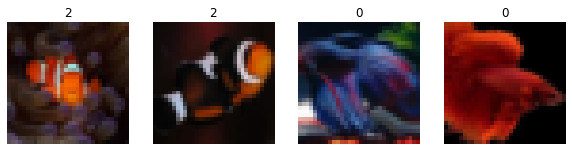

In [ ]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Betta Fish, 1 is Blue Tang, 2 is Clownfish, 3 is Lionfish

In [ ]:
#########################################################################
# this code is different to last week - here we define a CNN architecture
#########################################################################

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 4x4x64)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # fully connected layer 2 (input 500, output 4 - four classes)
        self.fc2 = nn.Linear(500, 4) 
        # dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Net()
print(model)

#########################################################################
#########################################################################

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.291731 	Validation Loss: 1.223467
Validation loss decreased (inf --> 1.223467).  Saving model ...
Epoch: 2 	Training Loss: 1.039642 	Validation Loss: 0.876668
Validation loss decreased (1.223467 --> 0.876668).  Saving model ...
Epoch: 3 	Training Loss: 0.834285 	Validation Loss: 0.758185
Validation loss decreased (0.876668 --> 0.758185).  Saving model ...
Epoch: 4 	Training Loss: 0.663165 	Validation Loss: 0.588326
Validation loss decreased (0.758185 --> 0.588326).  Saving model ...
Epoch: 5 	Training Loss: 0.541693 	Validation Loss: 0.517343
Validation loss decreased (0.588326 --> 0.517343).  Saving model ...
Epoch: 6 	Training Loss: 0.629859 	Validation Loss: 0.486312
Validation loss decreased (0.517343 --> 0.486312).  Saving model ...
Epoch: 7 	Training Loss: 0.445336 	Validation Loss: 0.490692
Epoch: 8 	Training Loss: 0.278009 	Validation Loss: 0.952988
Epoch: 9 	Training Loss: 0.345115 	Validation Loss: 0.648702
Epoch: 10 	Training Loss: 0.285523 	Valida

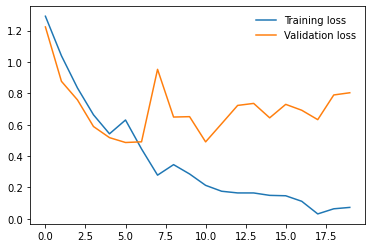

In [ ]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

In [ ]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.461181

Test Accuracy of     0: 53% ( 8/15)
Test Accuracy of     1: 100% (15/15)
Test Accuracy of     2: 86% (13/15)
Test Accuracy of     3: 80% (12/15)

Test Accuracy (Overall): 80% (48/60)


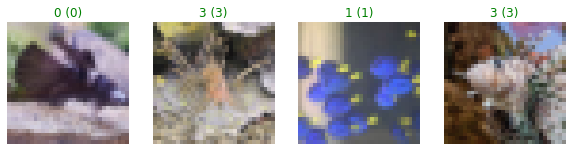

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
# 0 is Betta Fish, 1 is Blue Tang, 2 is Clownfish, 3 is Lion Fish

# WEEK 4

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/TropicalFish_Dataset.zip' > /dev/null

replace TropicalFish_Dataset/test/Bettafish/OIP (42).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# dataset directory
data_dir = 'TropicalFish_Dataset'

# define batch size
batch_size = 8

# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(236), # resize to 236x?
                                transforms.RandomRotation(5), # random rotation
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.RandomHorizontalFlip(), # randomly flip on horizontal axis
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# validation and testing
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

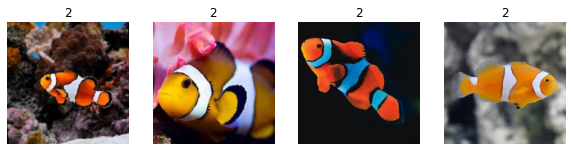

In [ ]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Betta Fish, 1 is Blue Tang, 2 is Clownfish, 3 is Lion Fish

In [ ]:
#########################################################################
# use a ResNet18 network
# #########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

import torch.nn as nn
import torchvision.models as models

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)

# # if we use the following code the pre-trained weights are frozen and we only update the final layer
# for param in model.parameters():
#     param.requires_grad = False

# get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# replace the final layer so that the output is number of classes
model.fc = nn.Linear(num_ftrs, 4)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

# #########################################################################
# #########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimiser (Adam optimiser) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 50

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.015817 	Validation Loss: 0.059309
Validation loss decreased (inf --> 0.059309).  Saving model ...
Epoch: 2 	Training Loss: 0.009268 	Validation Loss: 0.043288
Validation loss decreased (0.059309 --> 0.043288).  Saving model ...
Epoch: 3 	Training Loss: 0.005229 	Validation Loss: 0.015775
Validation loss decreased (0.043288 --> 0.015775).  Saving model ...
Epoch: 4 	Training Loss: 0.006414 	Validation Loss: 0.050885
Epoch: 5 	Training Loss: 0.083602 	Validation Loss: 0.054567
Epoch: 6 	Training Loss: 0.036994 	Validation Loss: 0.097859
Epoch: 7 	Training Loss: 0.021326 	Validation Loss: 0.020104
Epoch: 8 	Training Loss: 0.068230 	Validation Loss: 0.284556
Epoch: 9 	Training Loss: 0.093877 	Validation Loss: 0.527024
Epoch: 10 	Training Loss: 0.042123 	Validation Loss: 0.101332
Epoch: 11 	Training Loss: 0.016537 	Validation Loss: 0.055536
Epoch: 12 	Training Loss: 0.016692 	Validation Loss: 0.043282
Epoch: 13 	Training Loss: 0.023829 	Validation Loss: 0.058689
E

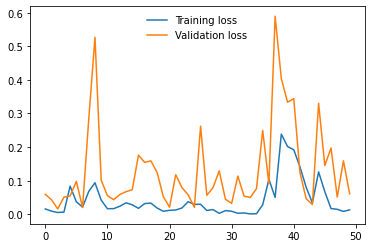

In [ ]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

In [ ]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.125438

Test Accuracy of     0: 100% (15/15)
Test Accuracy of     1: 93% (14/15)
Test Accuracy of     2: 100% (15/15)
Test Accuracy of     3: 93% (14/15)

Test Accuracy (Overall): 96% (58/60)


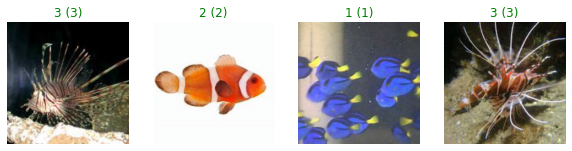

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
# 0 is Betta Fish, 1 is Blue Tang, 2 is Clownfish, 3 is Lion Fish

# WEEK 5 - T-SNE

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/TropicalFish_Dataset.zip' > /dev/null

replace TropicalFish_Dataset/test/Bettafish/OIP (42).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# dataset directory
data_dir = 'TropicalFish_Dataset'

# define batch size
batch_size = 80

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

In [ ]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet18(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 4)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

# print(myModel)

In [ ]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = model(images)
tropicalfish_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
tropicalfish_feats = np.squeeze(tropicalfish_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(tropicalfish_feats.shape)
print(labels)

(60, 512)
(60, 512)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


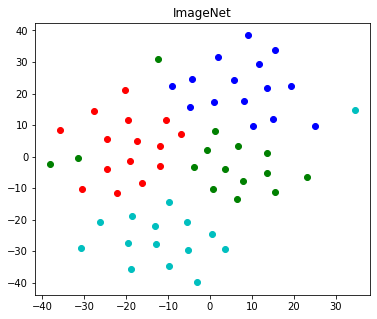

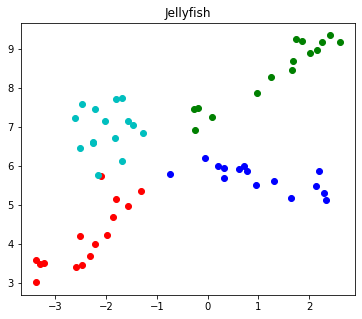

In [ ]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
tropicalfish_X_2d = tsne.fit_transform(tropicalfish_feats)

############################################################
# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Betta Fish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Blue Tang
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Clownfish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Lion Fish
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
plt.title('ImageNet')
# plt.show()

# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(tropicalfish_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Betta Fish
    plt.scatter(tropicalfish_X_2d[i,0], tropicalfish_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Blue Tang
    plt.scatter(tropicalfish_X_2d[i,0], tropicalfish_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Clownfish
    plt.scatter(tropicalfish_X_2d[i,0], tropicalfish_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Lion Fish
    plt.scatter(tropicalfish_X_2d[i,0], tropicalfish_X_2d[i, 1], c='c')
plt.title('Tropical Fish')
# plt.show()
plt.show()
 

# WEEK 5 - CLASS ACTIVATION MAPS

In [ ]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

fatal: destination path 'SmoothGradCAMplusplus' already exists and is not an empty directory.


In [ ]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [ ]:
import cam

In [ ]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/TropicalFish_Dataset.zip' > /dev/null

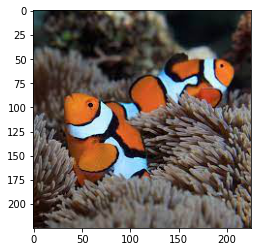

In [ ]:
# from ImageNet
image = Image.open('/content/TropicalFish_Dataset/train/Clownfish/download (1).jpg')
# image = Image.open('./sample/dogsled.jpg')
imshow(image)

In [ ]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [ ]:
model = models.resnet18(pretrained=True)
model.eval()
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# the target layer you want to visualize
target_layer = model.layer4[1].conv2

# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
# wrapped_model = GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [ ]:
cam, idx = wrapped_model(tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 393	 probability 0.9537649750709534


In [ ]:
print(idx2label[idx])

anemone fish


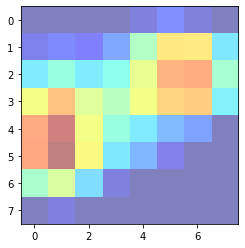

In [ ]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [ ]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [ ]:
heatmap = visualize(img, cam)

In [ ]:
# save image
# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

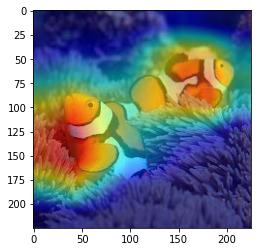

In [ ]:
# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)

# WEEK 6

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# loading my dataset here

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/tropicalfish_DCGAN.zip' > /dev/null

In [ ]:
# dataset directory
data_dir = 'tropicalfish_DCGAN'
# the data_dir must contain another folder with the images inside

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# WEEK 7 - STYLEGAN2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
if os.path.isdir("/content/drive/MyDrive/colab-sg2-ada-pytorch"):
    %cd "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch"
elif os.path.isdir("/content/drive/"):
    #install script
    %cd "/content/drive/MyDrive/"
    !mkdir colab-sg2-ada-pytorch
    %cd colab-sg2-ada-pytorch
    !git clone https://github.com/dvschultz/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU -O /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/pretrained/wikiart.pkl
else:
    !git clone https://github.com/dvschultz/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    %cd pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU
    %cd ../

!pip install ninja opensimplex torch==1.7.1 torchvision==0.8.2

In [ ]:
%cd "/content/drive/My Drive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch"
!git config --global user.name "test"
!git config --global user.email "test@test.com"
!git fetch origin
!git pull
!git stash
!git checkout origin/main -- train.py generate.py legacy.py closed_form_factorization.py flesh_digression.py apply_factor.py README.md calc_metrics.py training/stylegan2_multi.py training/training_loop.py util/utilgan.py

In [ ]:
os.mkdir('./datasets/square_images')

In [ ]:
!python /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/dataset_tool.py --source /content/drive/MyDrive/jelly_square.zip --dest /content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/datasets/square_images

In [ ]:
!mv '/content/drive/MyDrive/network-snapshot-027750.pkl' '/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch/pretrained'

In [ ]:
#required: definitely edit these!
dataset_path = './datasets/square_images/00000'
resume_from = './pretrained/wikiart.pkl'
# resume_from = './pretrained/network-snapshot-027750.pkl'
aug_strength = 0.0
train_count = 0
mirror_x = True
#mirror_y = False

#optional: you might not need to edit these
gamma_value = 50.0
augs = 'bg'
config = '11gb-gpu'
snapshot_count = 4

In [ ]:
!python train.py --gpus=1 --cfg=$config --metrics=None --outdir=./results --data=$dataset_path --snap=$snapshot_count --resume=$resume_from --augpipe=$augs --initstrength=$aug_strength --gamma=$gamma_value --mirror=$mirror_x --mirrory=False --nkimg=$train_count

In [ ]:
!python generate.py --outdir=/content/out/images/ --trunc=0.8 --seeds=10 --network='./pretrained/network-snapshot-027750.pkl'

In [ ]:
!python generate.py --outdir=/content/out/images/ --trunc=0.7 --size=1820-1024 --scale-type=symm --seeds=0-499 --network='./pretrained/network-snapshot-027750.pkl'

In [ ]:
!python generate.py --process="truncation" --outdir=/content/out/trunc-trav-3/ --start=-0.8 --stop=2.8 --increment=0.02 --seeds=470 --network='./pretrained/network-snapshot-027750.pkl'

In [ ]:
!python generate.py --outdir=/content/out/video1-w-0.5/ --space="z" --trunc=0.5 --process="interpolation" --seeds=463,470 --network='./pretrained/network-snapshot-027750.pkl'

In [ ]:
!python generate.py --outdir=out/video1-w/ --space="w" --trunc=1 --process="interpolation" --seeds=85,265,297,849 --network='./pretrained/network-snapshot-027750.pkl'

In [ ]:
!python generate.py --outdir=out/slerp-z/ --space="z" --trunc=1 --process="interpolation" --interpolation="slerp" --seeds=85,265,297,849 --network='./pretrained/network-snapshot-027750.pkl' --frames=24

In [ ]:
!python generate.py --outdir=out/slerp-w/ --space="w" --trunc=1 --process="interpolation" --interpolation="slerp" --seeds=85,265,297,849 --network='./pretrained/network-snapshot-027750.pkl' --frames=12

In [ ]:
!python generate.py --outdir=out/video-noiseloop-0.9d/ --trunc=0.8 --process="interpolation" --interpolation="noiseloop" --diameter=0.9 --random_seed=100 --network='./pretrained/network-snapshot-027750.pkl'

In [ ]:
!python generate.py --outdir=out/video-circularloop/ --trunc=1 --process="interpolation" --interpolation="circularloop" --diameter=800.00 --frames=720 --random_seed=90 --network='./pretrained/network-snapshot-027750.pkl'

# WEEK 7 - VOXEL51

In [ ]:
!pip install fiftyone

In [ ]:
!pip install tensorflow torch torchvision umap-learn

In [ ]:
!pip install ipywidgets>=7.5

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
# my jellyfish sample
dataset = foz.load_zoo_dataset(
    "open-images-v6", 
    split="train", 
    label_types=["classifications"], 
    classes = ["Jellyfish"],
    max_samples=1000,
    seed=51,
    shuffle=True,
    dataset_name="open-images-jellyfish-small",
)

In [ ]:
# # you can launch the fifty one app to look at the sample
# session = fo.launch_app(dataset)

In [ ]:
# export the dataset
# https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html

export_dir = "/content/data"

# Export the dataset
dataset.export(
    export_dir=export_dir, dataset_type=fo.types.ImageDirectory
)

In [ ]:
# square crop and resize to 512x512

import PIL
import os
import os.path
from PIL import Image

newsize = (512, 512)

square_dir = "/content/square"
os.mkdir(square_dir)

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

f = export_dir

for file in os.listdir(f):
    f_img = f+"/"+file
    im = Image.open(f_img)
    
    im_square = crop_max_square(im)

    im_square = im_square.resize(newsize)

    im_square.save(square_dir+"/"+file)

In [ ]:
# check size and colour format of images
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/square'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and sz!=base_size:
    print(f"Inconsistant size: {file2}")
  elif img.mode!='RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz

In [ ]:
# zip folder
!zip -r /content/square.zip /content/square > /dev/null

# WEEK 7 - DEEP MUSIC VISUALIZER

In [ ]:
# git clone the project folder
!git clone https://github.com/msieg/deep-music-visualizer.git

In [ ]:
# change root directory to `deep-music-visualizer`
%cd /content/deep-music-visualizer/

In [ ]:
# install dependencies
!pip install -r requirements.txt

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!mv '/content/gdrive/MyDrive/sound-of-coral-reef.mp3' '/content/deep-music-visualizer'

In [ ]:
!python visualize.py --song beethoven.mp3 --resolution 256 --duration 10
# !python visualize.py --song sound-of-coral-reef.mp3 --resolution 256 --duration 10

# WEEK 8 - PIX2PIX

In [ ]:
# git clone the project folder
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
# change root directory to 'pytorch-CycleGAN-and-pix2pix/'
import os
os.chdir('/content/pytorch-CycleGAN-and-pix2pix/')

In [ ]:
# install dependencies
!pip install -r requirements.txt

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# move dataset folder to /content/pytorch-CycleGAN-and-pix2pix/datasets
!mv '/content/drive/MyDrive/pix2pix_tropicalfish.zip' '/content/pytorch-CycleGAN-and-pix2pix/datasets'

In [ ]:
# unzip dataset folder
%cd 'datasets'
!unzip "pix2pix_tropicalfish.zip" > /dev/null
%cd '..'

In [ ]:
%cd '..'
print(os. getcwd())

In [ ]:
# run this script to generate combined images from your pairs of images.  Make sure you check the instructions to make sure you have the correct folder structure before uploading your dataset.
!python 'datasets/combine_A_and_B.py' --fold_A 'datasets/pix2pix_tropicalfish/A' --fold_B 'datasets/pix2pix_tropicalfish/B' --fold_AB 'datasets/pix2pix_tropicalfish'

In [ ]:
# visualise one of the combined images
import matplotlib.pyplot as plt

img = plt.imread('datasets/pix2pix_tropicalfish/train/im1.jpg')
plt.imshow(img)

In [ ]:
!python train.py --dataroot datasets/pix2pix_tropicalfish --name pix2pix_fish --model pix2pix --n_epochs 5 --n_epochs_decay 5 --direction BtoA

In [ ]:
!ls checkpoints/

In [ ]:
!python test.py --dataroot datasets/pix2pix_tropicalfish --model pix2pix --name pix2pix_fish

In [ ]:
img = plt.imread('./results/pix2pix_fish/test_latest/images/im520_fake_B.png')
plt.imshow(img)

In [ ]:
img = plt.imread('./results/pix2pix_fish/test_latest/images/im520_real_A.png')
plt.imshow(img)

In [ ]:
img = plt.imread('./results/pix2pix_fish/test_latest/images/im520_real_B.png')
plt.imshow(img)

# WEEK 8 - CYCLEGAN

In [ ]:
# git clone the project folder
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
# change root directory to 'pytorch-CycleGAN-and-pix2pix/'
import os
os.chdir('/content/pytorch-CycleGAN-and-pix2pix/')

In [ ]:
# install dependencies
!pip install -r requirements.txt

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/EUVP_Unpaired.zip' > /dev/null

In [ ]:
# move my dataset folder into pytorch-CycleGAN-and-pix2pix/datasets
!mv '/content/pytorch-CycleGAN-and-pix2pix/EUVP_Unpaired' '/content/pytorch-CycleGAN-and-pix2pix/datasets'

In [ ]:
# visualise examples from your training data
import matplotlib.pyplot as plt

img = plt.imread('./datasets//EUVP_Unpaired/trainA/nm_1000up.jpg')
plt.imshow(img)

In [ ]:
img = plt.imread('./datasets//EUVP_Unpaired/trainB/gmn_5001up.jpg')
plt.imshow(img)

In [ ]:
!python train.py --dataroot ./datasets/EUVP_Unpaired --name EUVP_CycleGAN --model cycle_gan --n_epochs 5 --n_epochs_decay 5 --save_epoch_freq 2 --checkpoints_dir '/content/gdrive/MyDrive/'

In [ ]:
cp /content/gdrive/MyDrive/EUVP_CycleGAN/latest_net_G_A.pth /content/gdrive/MyDrive/EUVP_CycleGAN/latest_net_G.pth

In [ ]:
!python test.py --dataroot ./datasets/EUVP_Unpaired/testA --name EUVP_CycleGAN --model test --no_dropout --checkpoints_dir '/content/gdrive/MyDrive/'

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./results/EUVP_CycleGAN/test_latest/images/test_9011up_fake.png')
plt.imshow(img)

In [ ]:
img = plt.imread('./results/EUVP_CycleGAN/test_latest/images/test_9011up_real.png')
plt.imshow(img)